# 3D Technologies
### Reduce Maintainance cost through predictive Techniques
August 2017  

Harsh Jain  


# Introduction

<b>
An engagement to build a Machine Learning model to predict probability of device failure.  
</b>

<b> Goal: </b> Predict PROBABILITY of device failure.

<b>Knowns: </b>
- Data is daily aggregated telemetry attributes.
- Response variable is 'failure' with binary value 0 for non-failure and 1 for failure.
- Need to minimize false positives and false negatives. 


<b>Assumptions: </b>
- This a classification problem and therefore will require Supervised Learning algorithms. 
- Deep Learning will be considered out of scope for this engagement. 

<b>Outline of the solution:</b>
1. Importing librararies and Data
2. Explore and Visualize the Data
3. Build a Benchmark model 
4. Build a Robust Classification algorithms.  
    4.1 Stratified K-fold Cross Validation  
    4.2 Hyperparameter tuning
    4.3 Fit and Predict
5. Metrics  
    5.1 Confusion Matrix and Classification Report  
    5.2 ROC curves and AUC  
6. Results
7. Conclusion
***

# Importing Libraries and Load Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [3]:
data = pd.read_csv('device_failure.csv')

IOError: File device_failure.csv does not exist

***
# Explore and Vizualize Data

In [18]:
data.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date          124494 non-null object
device        124494 non-null object
failure       124494 non-null int64
attribute1    124494 non-null int64
attribute2    124494 non-null int64
attribute3    124494 non-null int64
attribute4    124494 non-null int64
attribute5    124494 non-null int64
attribute6    124494 non-null int64
attribute7    124494 non-null int64
attribute8    124494 non-null int64
attribute9    124494 non-null int64
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


### Observations
No Categorical features  
No Missing Data. Probably has 0's or other 'filler values'  
Homogeneous Data types for attributes.  
Date field - may need to take into account. Correlation? 

***

### Please double check these calculations!

In [20]:
data.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,0.029167,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


### Observations
Most attributes have a min of 0.   
Attribute 2,3,4,7,8,9 have 25%,50%,75% percentile = 0. This means this is a very sparse dataset, with most values = 0  
Will validate this next..

Attribute Non-zero count [124483, 6384, 9135, 9338, 124494, 124494, 1458, 1458, 27136]
Attribute zero counts [11, 118110, 115359, 115156, 0, 0, 123036, 123036, 97358]


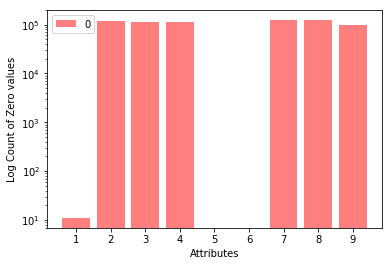

In [21]:
#Zero count to validate assumption
a = [np.count_nonzero(data.attribute1),np.count_nonzero(data.attribute2),
    np.count_nonzero(data.attribute3),np.count_nonzero(data.attribute4),
    np.count_nonzero(data.attribute5),np.count_nonzero(data.attribute6),
    np.count_nonzero(data.attribute7),np.count_nonzero(data.attribute8),
    np.count_nonzero(data.attribute9)]
print 'Attribute Non-zero count', a

zero_count = [(len(data) - x) for x in a]
print 'Attribute zero counts', zero_count

plt.bar(np.arange(1,10),zero_count, alpha=.5, color='r')
plt.yscale('log')
plt.xticks(np.arange(1,10))
plt.xlabel('Attributes')
plt.ylabel('Log Count of Zero values')
plt.legend('0', loc='best')
plt.show()

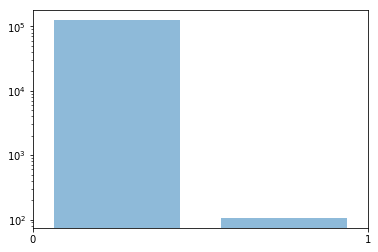

Count of failure:  106
Rate of failure:  0.085 %


In [22]:
#Target variable exploration - Class imbalance? 
plt.hist(data.failure, bins=2, rwidth=.75, alpha=.5, align='mid')
plt.xticks([0,1])
plt.yscale('log')
plt.show()
fail_count = np.count_nonzero(data.failure)

form = lambda x: "%.3f" % x

print 'Count of failure: ', fail_count
print 'Rate of failure: ', form(fail_count/float(len(data))*100), '%'

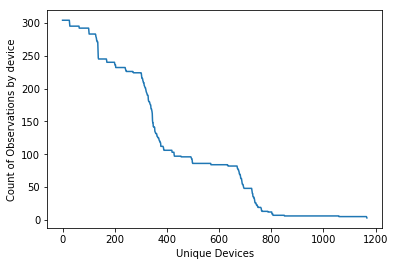

Number of unique devices:  1168
Percent of Device failure: 11.000 %


In [23]:
#Exploration by Device
x_device_count = data.device.nunique()
y_device_obs = data.device.value_counts()

plt.plot(np.arange(0,x_device_count), y_device_obs)
plt.xlabel('Unique Devices')
plt.ylabel('Count of Observations by device')
plt.show()
print "Number of unique devices: ", x_device_count
print "Percent of Device failure:", form((x_device_count/fail_count)), '%'

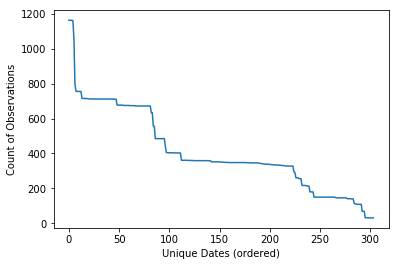

Number of unique dates:  304
Number of days with more than 2 Failures: 3


In [24]:
# Unique Dates and Number of obervations by Date [pre-sorted]
x_date_count = data.date.nunique()
y_day_plot = data.date.value_counts()
plt.plot(np.arange(0,x_date_count), y_day_plot)
plt.xlabel('Unique Dates (ordered)')
plt.ylabel('Count of Observations')
plt.show()

bydate = data.date.groupby([data.failure[data.failure == 1], data.date]).count()
bydate_count = bydate[bydate > 2].count()

print "Number of unique dates: ", x_date_count
print "Number of days with more than 2 Failures:", bydate_count

### Observations
   
All attributes other than 1,5,6 are are mostly 0 values.  
Very high Class Imbalance in dataset.  
Number of failures is 106 @ a 0.85% failure rate.  
< 1 % of minority class. Will need to tune models to account for such 'rare' true positive events.   
However, the total rate of device failure is not insignificant at @ 11%.  

Date is highly correlated to the Number of observations in dataset. However, only 3 days have more than 2 failures.  
- No co-relation of dates to failure.  
- Co-relation of Number of observation to dates can be addressed by shuffling when creating Cross Validation sets.

Need an algorithm that can handle highly skewed classes and sparse data.     
Also will need a stratified k-fold CV to provide the largest possible dataset for training.        
Use confusion matrix and AUC to measure, Minimize False Positives and False negatives. 
***

# Build a Benchmark model

Using a subset of data. Simple train/test split, no parameters or hyperparameter tuning. 

In [25]:
#Subset and split
bm_dtree = DecisionTreeClassifier()
bm_x = data[['attribute1', 'attribute5','attribute6']]
bm_y = data['failure']
bm_x_train, bm_x_test, bm_y_train, bm_y_test = train_test_split(bm_x, bm_y, test_size=.25, stratify=bm_y, random_state=412)

#Fit and Predict
bm_dtree.fit(bm_x_train, bm_y_train)
bm_predict = bm_dtree.predict_proba(bm_x_test)[:,1]

In [26]:

print 'Average probability of failure is', form((np.mean(bm_predict)*100)), '%'
print 'Number of positive predictions:', np.count_nonzero(bm_predict)
print 'Accuracy:', bm_dtree.score(bm_x_test, bm_y_test)

Average probability of failure is 0.067 %
Number of positive predictions: 21
Accuracy: 0.998457781776


In [27]:
print "Confusion Matrix \n",confusion_matrix(bm_y_test, bm_predict)
bm_fpr, bm_tpr, bm_threshold = roc_curve(bm_y_test, bm_predict)
bm_report = classification_report(bm_y_test, bm_predict, labels=[1], digits=3)
print bm_report

Confusion Matrix 
[[31076    21]
 [   27     0]]
             precision    recall  f1-score   support

          1      0.000     0.000     0.000        27

avg / total      0.000     0.000     0.000        27



### Observations
- Even though "Average probablility" and "Number of positive predictions" seem reasonable and Accuracy is at 99.8% these aren't a good measure because this is a highly skewed dataset with over 99% majority class.
- Measure using Confusion matrix, Precision, recall, F1 score, and AUC. This is a much better indicator or accuracy.   
- When using a confusion matrix and AUC, its evident that the model completely fails at prediction of positive events in test dataset.    
- With a minority class of < 1%, an AUC ~ 50% is not surprising and is expected due to the challenging nature of the data.   
***

# Build a Robust Model

Techniques we can implement to build a tuned and robust model to optimize model performance: 
- Use the full attribute list  
- Use multiple models to find which model performs best.  
- Use GridSearchCV to estimate hyperparameters for the various models.  
- Use Stratified KFold to split and cross-validate data to provide the largest possible training/test set.
- Shuffle folds to minimize impact of date co-relation.
- Use class weights to give importance to positive class. We can do this by using parameter 'class_weight' with a value = 'balanced'. This weight is calculated using n_samples / (n_classes * np.bincount(y)) and is equal to about 1: 585 in this case. [Reference](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 
- Assuming misclassification cost of False Positives = False Negatives, the best indicator of model accuracy is the measure that takes both Precision and Recall into accout. 
    - To evaluate model performance, F1 score and AUC should be used.   
    - Hyperparameters are also set to optimize for score='roc_auc'
- The models we will use don't require standardization, so no scaling will be implemented.  

Experiment using Supervised Learning Algorithms.  
- Decision Tree - Simple classification model. Works well with sparse datasets.
- Random Forest - Ensemble method to improve Decision tree performance and reduce individual feature variances.
- Logistic Regression - Classic classifier that can handle sparse datasets. Output probablilities, can tune 'C' parameter. 
- Gaussian Naive Bayes - well documented and 'baseline' classifier. Especially for high bias problems like spam detection.

Determine if and which algorithms are successful at predicting True Positives. Explore improvement techniques.

### Split Features and Response variable

In [28]:
x = data.drop(['date','device','failure'], axis=1)
y = data['failure']

In [29]:
#Instantiate the various Classification algorithms to try
dtree = DecisionTreeClassifier(class_weight='balanced')
randf = RandomForestClassifier(class_weight='balanced')
logreg = LogisticRegression(class_weight='balanced')
gnb = GaussianNB()

In [30]:
#Hyperparameter grid
dtree_paramgrid = {'max_depth': range(4,10)}
randf_paramgrid = {'n_estimators': range(4,20,2), 'max_depth': range(4,10)}
c_space = np.logspace(-3, 3, 7) 
logreg_paramgrid = {'C': c_space, 'penalty' : ('l1', 'l2')}

x_cv_dtree = GridSearchCV(dtree, dtree_paramgrid, cv = 3, scoring='f1')
x_cv_randf = GridSearchCV(randf, randf_paramgrid, cv = 3, scoring='f1')
x_cv_logreg = GridSearchCV(logreg, logreg_paramgrid, cv = 3, scoring='f1')
x_cv_gnb = gnb

In [32]:
#Initialize counters
i = 0
k=5 #Folds
y_test = y_dtree = y_randf = y_logreg = y_gnb = []

#Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=412)

for train,test in skf.split(x,y): 
    x_train, x_test = x.iloc[train], x.iloc[test]
    y_train, y_test_fold = y.iloc[train], y.iloc[test]

    #Fit and Predict
    i += 1
    print 'Split: ', i
    
    #dtree
    print ('Running Decision Tree...')
    x_cv_dtree.fit(x_train,y_train)
    y_pred_dtree_proba = x_cv_dtree.predict_proba(x_test)[:,1]

    #rand
    print ('Running Random Forest...')
    x_cv_randf.fit(x_train,y_train)
    y_pred_randf_proba = x_cv_randf.predict_proba(x_test)[:,1]    

    #logreg
    print ('Running Logistic Regression...')
    x_cv_logreg.fit(x_train,y_train)
    y_pred_logreg_proba = x_cv_logreg.predict_proba(x_test)[:,1]    

    #gnb
    print 'Running NaiveBayes... ', '\n'
    x_cv_gnb.fit(x_train,y_train)
    y_pred_gnb_proba = x_cv_gnb.predict_proba(x_test)[:,1]

    #Complile Test and prediction results
    y_test = np.append(y_test, y_test_fold)
    y_dtree = np.append(y_dtree, y_pred_dtree_proba)
    y_randf = np.append(y_randf, y_pred_randf_proba)
    y_logreg = np.append(y_logreg, y_pred_logreg_proba)
    y_gnb = np.append(y_gnb, y_pred_gnb_proba)

Split:  1
Running Decision Tree...
Running Random Forest...
Running Logistic Regression...
Running NaiveBayes...  

Split:  2
Running Decision Tree...
Running Random Forest...
Running Logistic Regression...
Running NaiveBayes...  

Split:  3
Running Decision Tree...
Running Random Forest...
Running Logistic Regression...
Running NaiveBayes...  

Split:  4
Running Decision Tree...
Running Random Forest...
Running Logistic Regression...


/opt/wakari/anaconda/lib/python2.7/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Running NaiveBayes...  

Split:  5
Running Decision Tree...
Running Random Forest...
Running Logistic Regression...
Running NaiveBayes...  



In [33]:
# Best Parameters
print 'Best Decision Tree Parameters:', x_cv_dtree.best_params_
print 'Best Random Forest Parameters:', x_cv_randf.best_params_
print 'Best Logistic Regression Parameters:', x_cv_logreg.best_params_
print 'Best Naive Bayes Parameters: N/A'

Best Decision Tree Parameters: {'max_depth': 5}
Best Random Forest Parameters: {'n_estimators': 12, 'max_depth': 8}
Best Logistic Regression Parameters: {'penalty': 'l1', 'C': 100.0}
Best Naive Bayes Parameters: N/A


### Observations
In Logistic Regression, L1 penalty lends itself to sparse datasets, so it makes sense that it led to the highest score. 

# Measure
Since the goal is not to maximize the True Positive predictions but to get a 'probability of failure' while minimizing both False Positives and False negatives, we will evaluate the best F1 scores and the AUC of the models to determine the winner.  

In [35]:
y_pred = [y_dtree.round(), y_randf.round(), y_logreg.round(), y_gnb.round()]

#Confusion matrices
conf_dtree = confusion_matrix(y_test, y_pred[0])
conf_randf = confusion_matrix(y_test, y_pred[1])
conf_logreg = confusion_matrix(y_test, y_pred[2])
conf_gnb = confusion_matrix(y_test, y_pred[3])

print 'Decision Tree:\n', conf_dtree
print '\nRandom Forest:\n', conf_randf
print '\nLogistic Regression:\n', conf_logreg
print '\nNaiveBayes:\n', conf_gnb

Decision Tree:
[[115458   8930]
 [    39     67]]

Random Forest:
[[123357   1031]
 [    96     10]]

Logistic Regression:
[[119591   4797]
 [    49     57]]

NaiveBayes:
[[124160    228]
 [    98      8]]


In [36]:
#Classification Report
report_dtree = classification_report(y_test, y_pred[0], labels=[1], digits=3)
report_randf = classification_report(y_test, y_pred[1],labels=[1], digits=3)
report_logreg = classification_report(y_test, y_pred[2],labels=[1], digits=3)
report_gnb = classification_report(y_test, y_pred[3],labels=[1], digits=3)

print 'Decision Tree Report:\n', report_dtree
print 'Random Forest Report:\n', report_randf
print 'Logistic Regression Report:\n', report_logreg
print 'Naive Bayes Report:\n', report_gnb

Decision Tree Report:
             precision    recall  f1-score   support

          1      0.007     0.632     0.015       106

avg / total      0.007     0.632     0.015       106

Random Forest Report:
             precision    recall  f1-score   support

          1      0.010     0.094     0.017       106

avg / total      0.010     0.094     0.017       106

Logistic Regression Report:
             precision    recall  f1-score   support

          1      0.012     0.538     0.023       106

avg / total      0.012     0.538     0.023       106

Naive Bayes Report:
             precision    recall  f1-score   support

          1      0.034     0.075     0.047       106

avg / total      0.034     0.075     0.047       106



### Observations
Best Precision: Naive Bayes has a much higher Precision than other models at .034.  
Best Recall: Decision Tree had the highest recall at 0.632.  
Best Fscore: The highest overall performance based on Confusion matrix was by Naive Bayes at an F1 score of 0.047. 

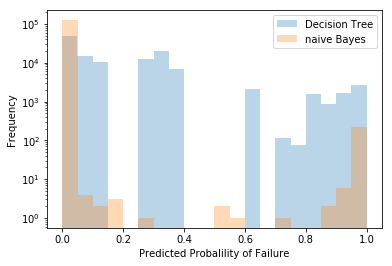

In [37]:
# Plot a Historgram of probablilies
plt.hist(y_dtree, bins=20, alpha=.3, label='Decision Tree')
plt.hist(y_gnb, bins=20, alpha=.3, label='naive Bayes')
plt.yscale('log')
plt.xlabel('Predicted Probalility of Failure')
plt.ylabel('Frequency')
plt.legend()
plt.show()

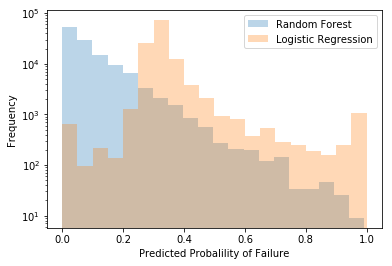

In [38]:
# Plot a Historgram of probablilies
plt.hist(y_randf, bins=20, alpha=.3, label='Random Forest')
plt.hist(y_logreg, bins=20, alpha=.3, label='Logistic Regression')
plt.yscale('log')
plt.xlabel('Predicted Probalility of Failure')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Observations  
Decision Tree and Naive Bayes predictions have low prediction probability cardinality.  
Random Forest and Logistic Regression have a much smoother distribution of probablilies.  
If varying the threshold to increase Precision or Recall is required, Random Forest or Logistic Regression should be used.  

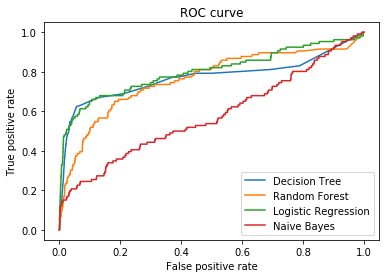

In [39]:
#Plot the ROC curve
fpr_dtree, tpr_dtree, threshold_dtree = roc_curve(y_test, y_dtree)
fpr_randf, tpr_randf, threshold_randf = roc_curve(y_test, y_randf)
fpr_logreg, tpr_logreg, threshold_logreg = roc_curve(y_test, y_logreg)
fpr_gnb, tpr_gnb, threshold_gnb = roc_curve(y_test, y_gnb)

plt.plot(fpr_dtree, tpr_dtree, label='Decision Tree')
plt.plot(fpr_randf, tpr_randf, label='Random Forest')
plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression')
plt.plot(fpr_gnb, tpr_gnb, label='Naive Bayes')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [40]:
#Calculate the Area Under the Curve
auc_dtree = roc_auc_score(y_test, y_dtree)
auc_randf = roc_auc_score(y_test, y_randf)
auc_logreg = roc_auc_score(y_test, y_logreg)
auc_gnb = roc_auc_score(y_test, y_gnb)

print 'AUC Decision Tree:', auc_dtree
print 'AUC Random Forest:', auc_randf
print 'AUC Logistic Regression:', auc_logreg
print 'AUC Naive Bayes:', auc_gnb

AUC Decision Tree: 0.771184322215
AUC Random Forest: 0.762274814473
AUC Logistic Regression: 0.801593735002
AUC Naive Bayes: 0.576670321289


# Results
<b>A high AUC is the most useful predictor for high class imbalance problems. </b>  
When given a positive and a negative event, it indicates the models propensity to assign a higher probability for a positive event.
The ROC curve also explains the discrepency between F1 score and AUC.  
Even though Naive Bayes has a higher F1 score, its predictions aren't affected by threshold, leading to a low overall AUC score.

The best performing models here are Logistic Regression and surprisingly Decision trees (Random forest wasn't far behind).  
<b> Logistic Regression AUC - 0.80    
Decision Tree AUC - 0.77   </b> 

Therefore the best models to consider and improve are Logistic Regression and Decision Trees (Xgboosted trees).
***

# Conclusion

The goal of the model was to predict the probability of device failure.   
- After some initial data exploration, it was found that the data set is (~124k observations with 9 attributes), is mostly sparse, doesn't have any missing or categorical data, but has a significant class imbalance.   
- After building a quick benchmark model, a more robust model was built with multiple algorithms, grid search parameters, stratified Kfold, and advanced parameter selection and tuning.   
- The results from the models were compared using F1 score and AUC.   
- Logistic regression and Decision Tree model yielded the most accurate results at 0.79 and 0.77 AUC scores respectively.    
- Additional techniques that can be used to improve the model:
    - XGBoost.  
    - Upsampling using SMOTE.  
    - Treat like an anomaly detection supervised learning model.  
    - SVM based approaches.  
    - Neural network based techniques.  
